In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from src.classifier_functions import *

import shap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


plt.style.use('ggplot')
%matplotlib inline 

### Reading in the Data

In [3]:
data = pd.read_csv('../users_final.csv')

In [100]:
final = pd.read_csv('../users_test.csv')

### Setting Up the Model

In [43]:
y = data['target'].values
X = data.iloc[:,:-1].values
X_train, X_test, y_train, y_test = train_test_split(X,y)


gbc = GradientBoostingClassifier(learning_rate =.2, n_estimators= 100,
                    max_features= 'sqrt',
                     max_depth= 4,
                     min_samples_leaf= 1,
                     min_samples_split= 2)
gbc.fit(X_train, y_train)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=4,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [45]:
y_hat = gbc.predict(X_test)

In [46]:
y_train_hat = gbc.predict(X_train)

### Dev Test Confusion Matrix and Stats 

In [94]:
scorecard(gbc, X_test, y_test, y_hat)


The Accuracy score is 0.851.
The Precision score is 0.719.
The Recall score is 0.573.
    Confusion Matrix


,Actual True,Actual False
Predicted True,779,305
Predicted False,581,4297


### Train Confusion Matrix and Stats

In [95]:
scorecard(gbc, X_train, y_train, y_train_hat)

The Accuracy score is 0.871.
The Precision score is 0.786.
The Recall score is 0.612.
    Confusion Matrix


,Actual True,Actual False
Predicted True,2554,696
Predicted False,1617,13019


In [14]:
precision_score(y_train, y_train_hat)

0.8169711985134717

### Final Test with Confusion Matrix and Stats

In [101]:
y_final = final['target'].values
X_final = final.iloc[:,:-1].values
y_final_hat = gbc.predict(X_final)

In [102]:
scorecard(gbc, X_final, y_final, y_final_hat)

The Accuracy score is 0.693.
The Precision score is 0.801.
The Recall score is 0.772.
    Confusion Matrix


,Actual True,Actual False
Predicted True,3956,981
Predicted False,1167,890


### Plotting the ROC Curve 

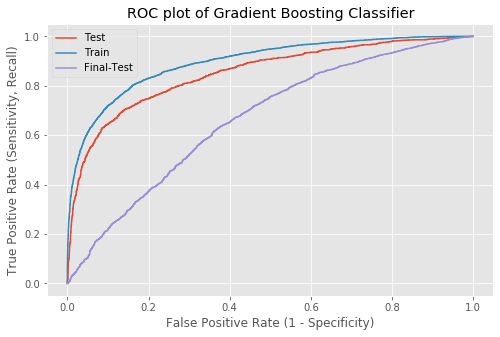

In [111]:
probabilities = gbc.predict_proba(X_test)[:, 1]
probabilities2 = gbc.predict_proba(X_train)[:, 1]
probabilitiesf= gbc.predict_proba(X_final)[:, 1]

tpr, fpr, thresholds = roc_curve_(probabilities, y_test)
tpr2, fpr2, thresholds2 = roc_curve_(probabilities2, y_train)
tprf, fprf, thresholdsf = roc_curve_(probabilitiesf, y_final)

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(fpr, tpr, label='Test')
ax.plot(fpr2, tpr2, label='Train')
ax.plot(fprf, tprf, label='Final-Test')
ax.set_xlabel("False Positive Rate (1 - Specificity)")
ax.set_ylabel("True Positive Rate (Sensitivity, Recall)")
ax.set_title("ROC plot of Gradient Boosting Classifier")
ax.legend()
plt.show()
fig.savefig('images/gbroc.png')

### Looking at Feature Importances 

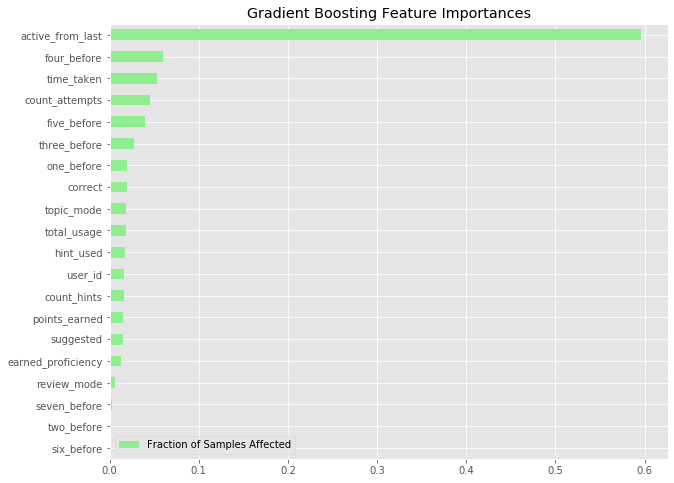

In [112]:
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : gbc.feature_importances_},
                           index=data.columns.values[:-1])
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh', figsize=(10,8), color='lightgreen', title='Gradient Boosting Feature Importances',)
fig.savefig('images/gbfi.png')

### Grid Search Results 


In [97]:
gb = GradientBoostingClassifier()

gb_random = GridSearchCV(estimator = gb, cv= 5, param_grid = random_grid,  n_jobs = -1)
# Fit the random search model


In [98]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 5000, num =10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2,8,6)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

{'n_estimators': [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 3, 4, 5, 6, 8, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [99]:
gb_random.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no...
                                                  subsample=1.0, tol

In [100]:
gb_random.best_params_

{'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}